I hope this is not disappointing, but the "Julia" of the title is the [Julia programming language](https://julialang.org).

A few weeks ago I went to a workshop run by the Turing Institute, about planning Tools Practices and Systems for data science.

We had a free-form session in which we could list *opportunities* for data science tools.  One person had put up a suggestion "JULIA: do it all in ONE language".

Julia is very young.
[Wikipedia](https://en.wikipedia.org/wiki/Julia_%28programming_language%29)
claims it started in 2009.  It has far fewer users than the big data science
languages like Python and R.  The first stable release was
[1.0](https://julialang.org/blog/2018/08/one-point-zero), in August 2018.

It does have some advantages over these languages.  Because it is so new, it
can use the older languages as examples of good and bad design.  Julia is
designed for speed, and runs much much faster than not-optimized Python code,
and considerably faster than most Python code optimized with packages such as
[Cython](https://cython.org) and [Numba](https://numba.pydata.org).

Like Python and R, it has a relatively readable high-level syntax that is designed to appeal to scientist programmers.

It already has a place in numerical computing, and it has some users in finance.  The question for those of us teaching data analysis is - will it take off, to become a serious competitor for R and / or Python?  Should we be teaching Julia to graduates or undergraduates?

This blog post records my attempts to address this question with data I had to hand.

The source for this document is a Jupyter Notebook. You can get the original `hows-julia.ipynb` notebook from the [Github
repository of this blog](https://github.com/matthew-brett/asterisk-blog).

## Summary

I collected time-series data from the Julia language repository commits, proportion of Github PRs, and two language ranking sites.

The data are noisy, and it is difficult to draw firm conclusions.  If anything,
they suggest that Julia's growth has slowed over the last year, relative to two
obvious competitors: Python and R.

## Health of the Julia repository

First I looked at the code repository for the language itself.  This has the
code for the base Julia language and its standard libraries.

In [1]:
from collections import Counter
import datetime as dt
import itertools

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

I used some [code to analyze commit history](https://gist.github.com/tacaswell/e95cb2d57ca3783ffc40) kindly posted by Thomas Caswell.

Following Thomas' recipe, I first took a local clone of the [Julia Language repository](https://github.com/JuliaLang/julia).

I continued the recipe by using Git on the local clone to extract author + commit date from the Git version control repository from January 1 2013 till now.

```
echo 'time&name' > julia_commits.csv; 
git log --no-merges --since=2013-01-01 --pretty=format:'%at&%aN <%aE>' >> julia_commits.csv
```

There's a copy of `julia_commits.csv` in
[downloads/julia_commits.csv](../downloads/julia_commits.csv).

In [2]:
commits = pd.read_csv('downloads/julia_commits.csv', sep='&')

The first piece of code shows the cumulative plot of the number of
commits, by committer number, where the committer numbers give the order or
each committer in terms of number of commits.  Committers with more commits
have lower committer numbers. The plot shows that a few committers have made
the large majority of commits, but there is a reasonably large number of
contributors.

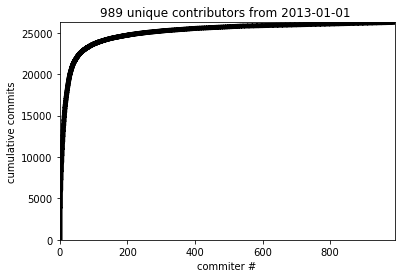

In [3]:
commiters = Counter(commits['name'])
commiter_number = list(range(len(commiters) + 1))
c_count = list(commiters.values())
cum_commits = np.r_[[0], np.cumsum(sorted(c_count, reverse=True))]

fig, ax = plt.subplots()
ax.step(commiter_number, cum_commits, where='post', color='k', lw=5)
ax.tick_params(axis='y', direction='out')
ax.tick_params(axis='x', direction='out')
ax.set_xlim([0, max(commiter_number)])
ax.set_ylim([0, np.sum(c_count)])
ax.set_ylabel('cumulative commits')
ax.set_xlabel('commiter #')
ax.set_title("{} unique contributors from 2013-01-01 ".
             format(max(commiter_number)-1));

Next plot the number of commits and number of committers per week:

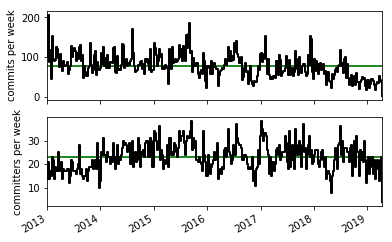

In [4]:
def stats_plotter(ax, left_edges, unq_by_week, col, ylabel):
    ln, = ax.step(left_edges,
                  unq_by_week[col], color='k', where='post', lw=2)

    hln = ax.axhline(unq_by_week[col].mean(), color='forestgreen', zorder=0, lw=2)
    ax.set_ylabel(ylabel)
    return ln, hln


def by_window_binner(ax1, ax2, commits, start, stop, step, window_name):
    edges = np.arange(start, stop + step, step)
    left_edges = [dt.datetime.fromtimestamp(t) for t in edges[:-1]]

    gb = commits.groupby(pd.cut(commits['time'], edges))
    unq_by_bin = gb.agg(lambda x: len(set(x)))

    stats_plotter(ax1, left_edges, unq_by_bin, 'time', 'commits per {}'.format(window_name))
    stats_plotter(ax2, left_edges, unq_by_bin, 'name', 'committers per {}'.format(window_name))

start = dt.datetime(2013, 1, 1).timestamp()
stop  = dt.datetime.now().timestamp()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
by_window_binner(ax1, ax2, commits, start, stop, 7*24*60*60, 'week')
ax1.set_xlim((dt.datetime(2013, 1, 1), dt.datetime(2019, 4, 10)))
fig.autofmt_xdate()

These plots suggest that Julia development has been burning along at a fairly
constant rate, until 2018, when the development rate falls, apart from a burst
before the August 2018 release of version 1.0.

## Percentage of all Github pull requests

If Julia is gaining traction, I would expect there to be more Julia code reaching open-source coding websites, such as Github.

I don't have those values, but [GitHut 2.0](https://madnight.github.io/githut)
does provide the *proportion* of Github pull-requests (PRs) in each language.
For example, in the case of Julia, we can see the proportion that is the number
of Github PRs in the Julia language, divided by the number of all PRs on Github
for the same period.

I scraped [these data](../downloads/julia_gh_prs.csv) by hand from the Githut
\2.0 site.

Here is a plot of these proportions for R and Julia.

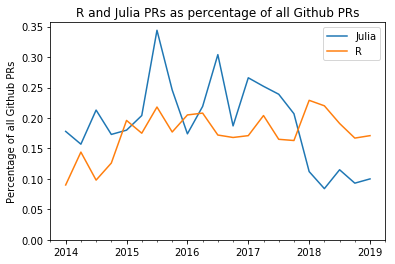

In [5]:
julia_prs = pd.read_csv('downloads/julia_gh_prs.csv')
julia_prs['Month'] = (julia_prs['Quarter'] - 1) * 3 + 2
datish = julia_prs.apply(
    lambda x: f"{x['Year']:0.0f}-{x['Month']:0.0f}", axis=1)
julia_prs.index = pd.to_datetime(datish)
ax = julia_prs.plot(y='Julia', use_index=True)
julia_prs.plot(y='R', use_index=True, ax=ax)
plt.title("R and Julia PRs as percentage of all Github PRs")
plt.ylabel('Percentage of all Github PRs')
plt.ylim(0);

The PR numbers for Julia look rather like the commit plot for the Julia language repository, and suggest that relative activity dropped off in 2018, compared to 2017.

Here are the values for Python, R and Julia for the last year:

In [6]:
julia_prs.head(4)[['Python', 'R', 'Julia']]

,Python,R,Julia
2019-02-01,17.891,0.171,0.100
2018-11-01,17.739,0.167,0.093
2018-08-01,17.503,0.191,0.115
2018-05-01,16.256,0.220,0.084


This is the matching plot of PR proportions for Python.  Note the values on the y axis.

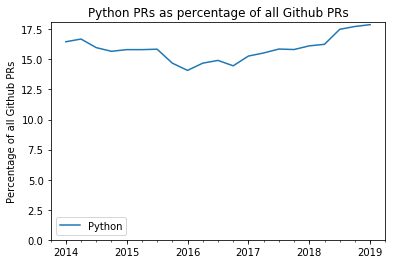

In [7]:
julia_prs.plot(y='Python', use_index=True)
plt.title("Python PRs as percentage of all Github PRs")
plt.ylabel('Percentage of all Github PRs')
plt.ylim(0);

## TIOBE language index

The [TIOBE language index](https://www.tiobe.com/tiobe-index) tries to quantify the popularity of programming languages.  Quoting from the URL above:

> The ratings are based on the number of skilled engineers world-wide, courses
> and third party vendors. Popular search engines such as Google, Bing, Yahoo!,
> Wikipedia, Amazon, YouTube and Baidu are used to calculate the ratings

I recovered the TIOBE index for Julia for each month from January 2017 to April
\2019, using the archived versions of the URL above, from <https://archive.org>.

The data file with the index values is
[downloads/julia_tiobe.csv](../downloads/julia_tiobe.csv).

Some values were below the reporting threshold for the TIOBE index, in which case I gave Julia the index value for the lowest language that was reported.  This will be a slight overestimate of Julia's value.  I've marked these below-threshold values with orange dots.

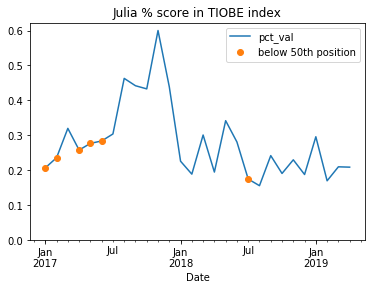

In [8]:
julia_tiobe = pd.read_csv('downloads/julia_tiobe.csv')
julia_tiobe['pct'] = julia_tiobe['pct'].apply(lambda x : x.strip())
julia_tiobe['pct_val'] = julia_tiobe['pct'].apply(
    lambda x : float(x[1:] if x.startswith('<') else x))
julia_tiobe.index = pd.to_datetime(julia_tiobe['year_month'])
ax = julia_tiobe.plot(y='pct_val', use_index=True)
belows = julia_tiobe[julia_tiobe['pct'].apply(lambda x : x.startswith('<'))]
belows.plot(y='pct_val', use_index=True,
            style='o', label='below 50th position', ax=ax)
plt.title('Julia % score in TIOBE index')
plt.xlabel('Date')
plt.ylim(0);

The plot looks a little like the Julia repository commit numbers; the popularity index has
a peak in late 2017, but drops in 2018 to a fairly steady fairly low value, of
around 0.2%.  For comparison, the April 2018 values for Python and R were
\8.166% and 1.181%, respectively.

## Redmonk Programming Language Rankings / Stack Overflow

Redmonk releases the [Redmonk ratings](https://redmonk.com/sogrady/category/programming-languages) every quarter.  Quoting from the [2019 first quarter ratings](https://redmonk.com/sogrady/2019/03/20/language-rankings-1-19) page:

> ... we extract language rankings from GitHub and Stack Overflow, and combine
> them for a ranking that attempts to reflect both code (GitHub) and discussion
> (Stack Overflow) traction.

Redmonk does not give tables with their graphics, that I can see, but here are
the rankings for Julia, from the main text of the [Q1 2019
rankings](https://redmonk.com/sogrady/2019/03/20/language-rankings-1-19) and
the [Q3 2018
rankings](https://redmonk.com/sogrady/2018/08/10/language-rankings-6-18).

| Year | Quarter | Position |
|------|---------|----------|
| 2019 | 1       | 34       |
| 2018 | 3       | 36       |
| 2018 | 2       | 39       |
| 2018 | 1       | 40       |
| 2017 | 4       | 52       |

These rankings are a bit more positive for Julia, suggesting that it is slowly
growing in popularity.

For comparison, for the first quarter of 2019, Python is at position 3, and R
is at position 15.

Some data for these rankings come from [Stack Overflow
data](https://insights.stackoverflow.com/trends).  Here is the percentage of
Stack Overflow questions on Julia:

![](images/so_julia.png)

There is a spike in late 2018, perhaps corresponding to the first release.  This might also account for its two-position jump in the Redmonk table.

You can run that query on current data with [this
URL](https://insights.stackoverflow.com/trends?tags=julia-lang).

Here are the results from the equivalent query for R and Python:

![](images/so_r_python.png)

This is the matching [query URL](https://insights.stackoverflow.com/trends?tags=r%2Cpython)